# **Rag From Scratch: Overview**

In [43]:
!pip install --upgrade --quiet groq langchain_groq bs4 langchain_community chromadb langchain_huggingface tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.0 MB/s eta 0:00:00


In [37]:
import os
from google.colab import userdata
from uuid import uuid4

unique_id = uuid4()
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Tracing Walkthrough - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["USER_AGENT"] = "myagent"

In [63]:
from groq import Groq
from langchain_groq import ChatGroq
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_huggingface import HuggingFaceEmbeddings
from IPython.display import Markdown, display
import tiktoken
import numpy as np
from langchain.prompts import ChatPromptTemplate

## Part 1: Overview

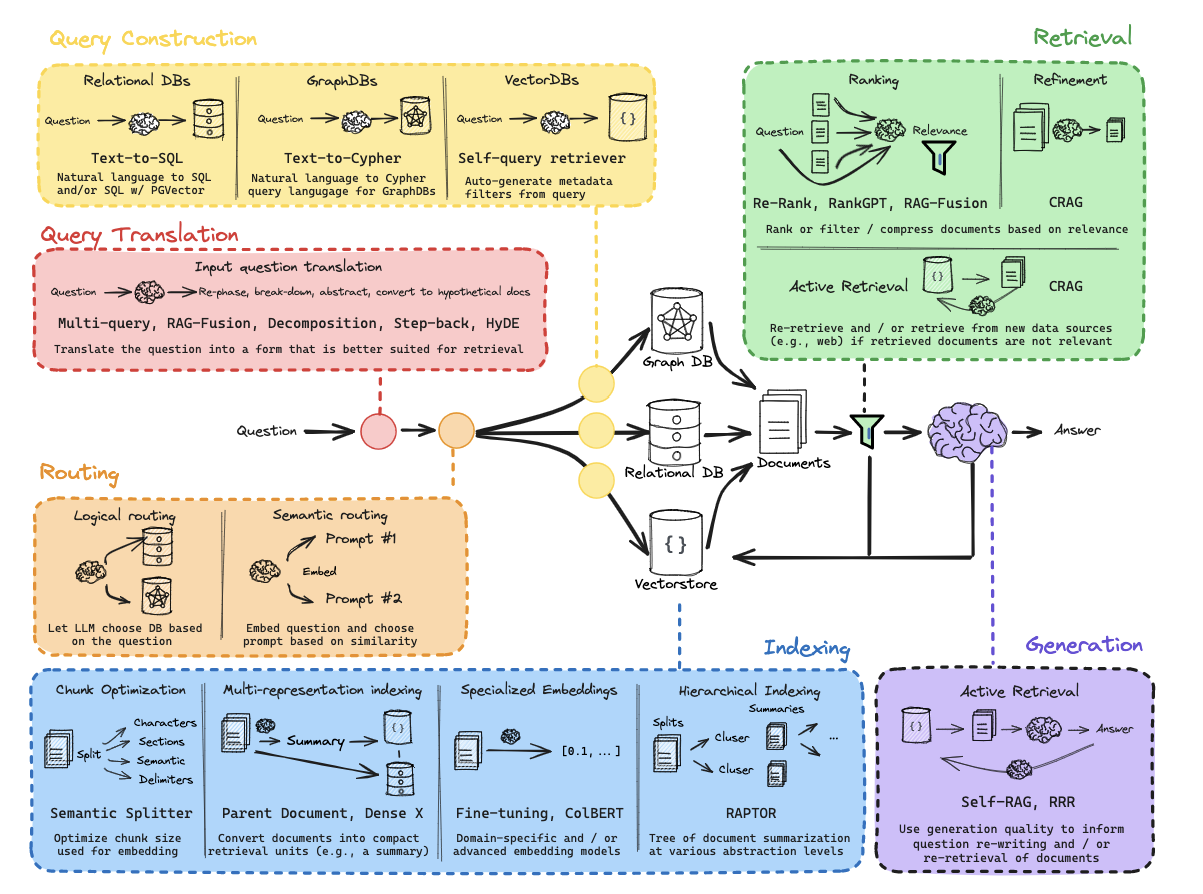

In [39]:
#### INDEXING ####

# Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Embed
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = Chroma.from_documents(documents=splits,
                                    embedding=embeddings)

retriever = vectorstore.as_retriever()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [40]:
#### RETRIEVAL and GENERATION ####

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatGroq(
    model="llama3-8b-8192",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
display(Markdown(rag_chain.invoke("What is Task Decomposition?")))

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:322: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Task Decomposition is a technique that breaks down complex tasks into smaller, simpler steps, allowing the model to "think step by step" and utilize more test-time computation. This process transforms big tasks into multiple manageable tasks, providing insight into the model's thinking process.

## Part 2: Indexing

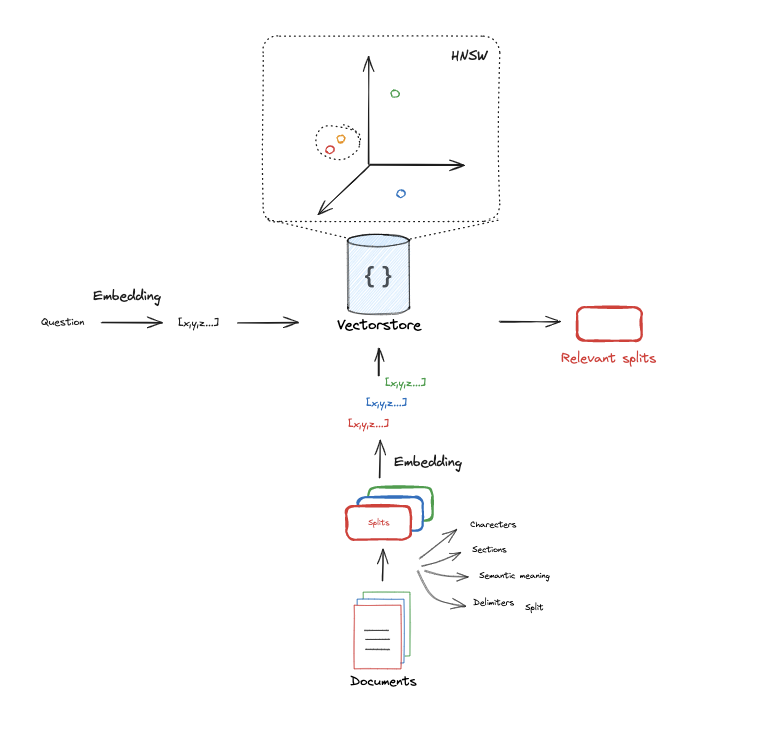

In [41]:
# Documents
question = "What kinds of pets do I like?"
document = "My favorite pet is a cat."

In [46]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

num_tokens_from_string(question, "cl100k_base")

8

In [51]:
embd = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
query_result = embd.embed_query(question)
document_result = embd.embed_query(document)
len(query_result)

384

In [49]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

similarity = cosine_similarity(query_result, document_result)
print("Cosine Similarity:", similarity)

Cosine Similarity: 0.5782657054688973


In [52]:
#### INDEXING ####

# Load blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

In [53]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300,
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

In [54]:
vectorstore = Chroma.from_documents(documents=splits,
                                    embedding=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2"))

retriever = vectorstore.as_retriever()

## Part 3: Retrieval

In [55]:
vectorstore = Chroma.from_documents(documents=splits,
                                    embedding=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2"))


retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

In [60]:
docs = retriever.get_relevant_documents("What is Task Decomposition?")
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.')]

In [59]:
len(docs)

1

## Part 4: Generation

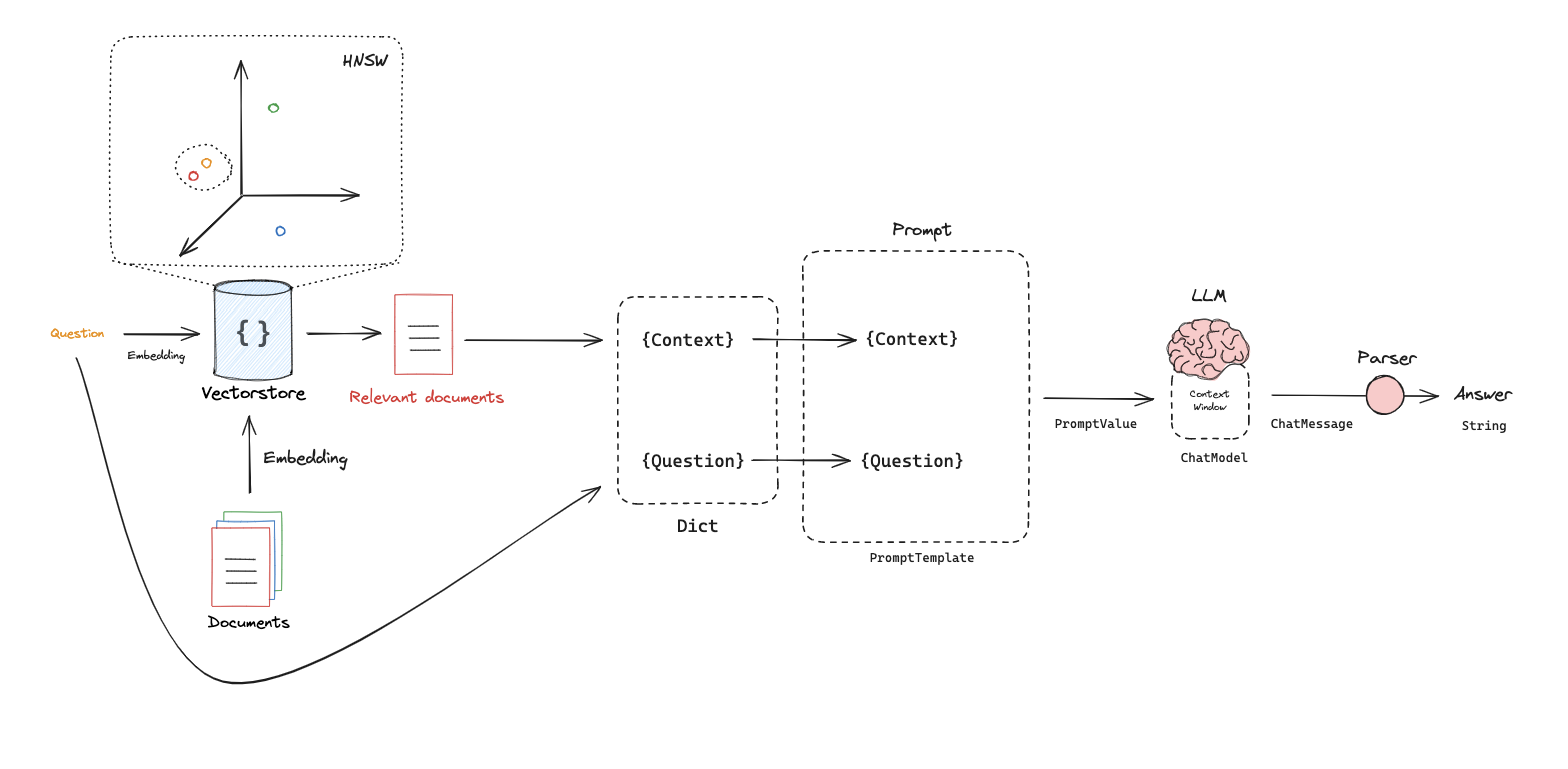

In [64]:
# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n{context}\n\nQuestion: {question}\n'), additional_kwargs={})])

In [65]:
# LLM
llm = ChatGroq(
    model="llama3-8b-8192",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [66]:
# Chain
chain = prompt | llm

In [67]:
# Run
chain.invoke({"context":docs,"question":"What is Task Decomposition?"})

AIMessage(content='According to the context, Task Decomposition is the process of breaking down a complicated task into smaller and simpler steps.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 185, 'total_tokens': 209, 'completion_time': 0.02, 'prompt_time': 0.03751745, 'queue_time': 0.0016345590000000007, 'total_time': 0.05751745}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6a6771ae9c', 'finish_reason': 'stop', 'logprobs': None}, id='run-38ebd44d-e7d7-46f2-a49a-1c15e99c1274-0', usage_metadata={'input_tokens': 185, 'output_tokens': 24, 'total_tokens': 209})

In [68]:
from langchain import hub
prompt_hub_rag = hub.pull("rlm/rag-prompt")

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:322: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [69]:
prompt_hub_rag

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [70]:

from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

'According to the context, Task Decomposition is the process of breaking down a complicated task into smaller and simpler steps.'